In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from torch.autograd import Variable
import sys
import numpy as np
import pickle
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch_geometric.nn import GCNConv
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv, GatedGraphConv
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
features = np.load(f'DataSet/Diff_GCN.npz')['features']
labels = np.load(f'DataSet/Diff_GCN.npz')['labels']
print(features.shape, labels.shape)

(90000, 24, 8) (90000, 24, 8)


In [3]:
# features = features[0:900]
# labels = labels[0:900]

In [4]:
class MyDataset():
    def __init__(self, features, labels):
        """
        features 和 labels 应该是形状为(90000, 24, 8)的numpy数组或者torch张量
        """
        self.features = features
        self.labels = labels

    def __len__(self):
        # 每9个数据形成一组，所以总长度是数据总数除以9
        return len(self.features) // 9

    def __getitem__(self, idx):
        # idx为组的索引，每个idx对应9个数据点
        start_idx = idx * 9
        end_idx = start_idx + 9
        feature = self.features[start_idx:end_idx]
        label = self.labels[start_idx:end_idx]
        return feature, label

In [5]:
# 转换为torch张量，如果已经是张量则可以跳过这步
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# 划分数据为训练集和测试集
train_features = features[:72000]  # 假设80%为训练数据
train_labels = labels[:72000]
test_features = features[72000:]
test_labels = labels[72000:]

# 创建Dataset对象
train_dataset = MyDataset(train_features, train_labels)
test_dataset = MyDataset(test_features, test_labels)

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# 使用DataLoader
for features, labels in train_loader:
    print(features.shape)  # 应该输出 (batch_size, 9, 24, 8)
    print(labels.shape)    # 同上
    break  # 仅展示第一个batch的形状

torch.Size([20, 9, 24, 8])
torch.Size([20, 9, 24, 8])


In [6]:

class TemporalGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, use_gat=False):
        super(TemporalGCNLayer, self).__init__()
        if use_gat:
            self.gcn = GATConv(in_channels, out_channels)
        else:
            self.gcn = GCNConv(in_channels, out_channels)
        self.bn = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        batch_size, num_nodes, num_timesteps, num_features = x.shape
        x = x.permute(2, 0, 1, 3).reshape(num_timesteps, batch_size * num_nodes, num_features)
        
        output = []
        for t in range(num_timesteps):
            out_t = self.gcn(x[t], edge_index)
            out_t = self.bn(out_t)
            out_t = self.dropout(out_t)
            output.append(out_t)
        
        output = torch.stack(output, dim=0).reshape(num_timesteps, batch_size, num_nodes, -1)
        return output.permute(1, 2, 0, 3)
    
class ResidualTemporalGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, use_gat=False):
        super(ResidualTemporalGCNLayer, self).__init__()
        self.gcn = TemporalGCNLayer(in_channels, out_channels, use_gat)
        self.residual = (in_channels == out_channels)

    def forward(self, x, edge_index):
        identity = x
        x = self.gcn(x, edge_index)
        if self.residual:
            x += identity
        return x

class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, edges):
        super(GCNModel, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.edges = torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)
        self.layer1 = ResidualTemporalGCNLayer(num_features, hidden_dim, use_gat=True)
        self.layer2 = ResidualTemporalGCNLayer(hidden_dim, num_classes, use_gat=False)

    def forward(self, x):
        edge_index = self.edges
        x = self.layer1(x, edge_index)
        x = self.layer2(x, edge_index)
        return x

In [7]:
num_features = 8  # initial feature dimension
hidden_dim = 512   # hidden dimension for the GCN layers
num_classes = 8   # output feature dimension (same as input to predict changes)
edges = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8), (0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8)]
model = GCNModel(num_features, hidden_dim, num_classes, edges)

In [8]:
# 创建一个简单的邻接矩阵和示例数据
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Example usage
num_batches = 20
num_nodes = 9
num_timesteps = 24
num_features = 8
x = torch.randn(num_batches, num_nodes, num_timesteps, num_features).to(device)
model = model.to(device)
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([20, 9, 24, 8])


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.MSELoss()
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

GCNModel(
  (layer1): ResidualTemporalGCNLayer(
    (gcn): TemporalGCNLayer(
      (gcn): GATConv(8, 512, heads=1)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (layer2): ResidualTemporalGCNLayer(
    (gcn): TemporalGCNLayer(
      (gcn): GCNConv(512, 8)
      (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
)

In [190]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    progress_bar = tqdm(data_loader, desc='Training', leave=True)
    for src, tgt in progress_bar:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()  
        output = model(src)
        loss = criterion(output, tgt)  
        loss.backward() 
        optimizer.step()  
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        
    average_loss = total_loss / len(data_loader)
    return average_loss

def validate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt_output = src.to(device), tgt.to(device)
            output = model(src)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [191]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
num_epochs = 50
writer = SummaryWriter(log_dir='runs/GCN')

# initial_params = [param.clone().detach() for param in model.parameters()]

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    writer.add_scalar('Loss/train', train_loss, epoch)
    val_loss = validate_epoch(model, test_loader, criterion, device)
    writer.add_scalar('Loss/val', val_loss, epoch)    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")
writer.close()

cuda


Training: 100%|██████████| 400/400 [00:20<00:00, 19.39it/s, loss=0.82] 


Epoch 1: Train Loss = 1.3503, Validation Loss = 0.5594


Training: 100%|██████████| 400/400 [00:19<00:00, 20.23it/s, loss=0.283]


Epoch 2: Train Loss = 0.5059, Validation Loss = 0.1776


Training: 100%|██████████| 400/400 [00:19<00:00, 20.19it/s, loss=0.0902]


Epoch 3: Train Loss = 0.1543, Validation Loss = 0.0581


Training: 100%|██████████| 400/400 [00:20<00:00, 19.52it/s, loss=0.0185]


Epoch 4: Train Loss = 0.0427, Validation Loss = 0.0258


Training: 100%|██████████| 400/400 [00:20<00:00, 19.52it/s, loss=0.0186] 


Epoch 5: Train Loss = 0.0186, Validation Loss = 0.0205


Training: 100%|██████████| 400/400 [00:20<00:00, 19.53it/s, loss=0.0103] 


Epoch 6: Train Loss = 0.0153, Validation Loss = 0.0203


Training: 100%|██████████| 400/400 [00:20<00:00, 19.10it/s, loss=0.0101] 


Epoch 7: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.68it/s, loss=0.0177] 


Epoch 8: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:19<00:00, 20.02it/s, loss=0.011]  


Epoch 9: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.72it/s, loss=0.011]  


Epoch 10: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.28it/s, loss=0.0107] 


Epoch 11: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.83it/s, loss=0.0117] 


Epoch 12: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:19<00:00, 20.03it/s, loss=0.016]  


Epoch 13: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.62it/s, loss=0.0146] 


Epoch 14: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.86it/s, loss=0.0192] 


Epoch 15: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.87it/s, loss=0.016]  


Epoch 16: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:19<00:00, 20.27it/s, loss=0.0165] 


Epoch 17: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:19<00:00, 20.22it/s, loss=0.0152] 


Epoch 18: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.91it/s, loss=0.0111] 


Epoch 19: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:19<00:00, 20.30it/s, loss=0.0103] 


Epoch 20: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.79it/s, loss=0.0192] 


Epoch 21: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.71it/s, loss=0.0132] 


Epoch 22: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:21<00:00, 18.97it/s, loss=0.0129] 


Epoch 23: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:21<00:00, 18.72it/s, loss=0.0103] 


Epoch 24: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:21<00:00, 18.82it/s, loss=0.0109] 


Epoch 25: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.81it/s, loss=0.0121] 


Epoch 26: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.75it/s, loss=0.0105] 


Epoch 27: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.21it/s, loss=0.0127] 


Epoch 28: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:21<00:00, 18.67it/s, loss=0.0117] 


Epoch 29: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.10it/s, loss=0.0136] 


Epoch 30: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.18it/s, loss=0.0229] 


Epoch 31: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.63it/s, loss=0.0175] 


Epoch 32: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.92it/s, loss=0.0102] 


Epoch 33: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.92it/s, loss=0.0187] 


Epoch 34: Train Loss = 0.0150, Validation Loss = 0.0203


Training: 100%|██████████| 400/400 [00:19<00:00, 20.21it/s, loss=0.0165] 


Epoch 35: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.40it/s, loss=0.0185] 


Epoch 36: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:19<00:00, 20.15it/s, loss=0.0136] 


Epoch 37: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:19<00:00, 20.41it/s, loss=0.0126] 


Epoch 38: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:21<00:00, 18.79it/s, loss=0.0162] 


Epoch 39: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.41it/s, loss=0.0196] 


Epoch 40: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.46it/s, loss=0.0167] 


Epoch 41: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.59it/s, loss=0.0163] 


Epoch 42: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.63it/s, loss=0.0109] 


Epoch 43: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:19<00:00, 20.18it/s, loss=0.013]  


Epoch 44: Train Loss = 0.0150, Validation Loss = 0.0203


Training: 100%|██████████| 400/400 [00:20<00:00, 19.12it/s, loss=0.0149] 


Epoch 45: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.42it/s, loss=0.012]  


Epoch 46: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.26it/s, loss=0.0124] 


Epoch 47: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.66it/s, loss=0.0181] 


Epoch 48: Train Loss = 0.0150, Validation Loss = 0.0201


Training: 100%|██████████| 400/400 [00:20<00:00, 19.76it/s, loss=0.0147] 


Epoch 49: Train Loss = 0.0150, Validation Loss = 0.0202


Training: 100%|██████████| 400/400 [00:20<00:00, 19.21it/s, loss=0.0161] 


Epoch 50: Train Loss = 0.0150, Validation Loss = 0.0202


In [192]:
torch.save(model.state_dict(), 'Model_Path/GWNet.pth')

In [10]:
model = GCNModel(num_features, hidden_dim, num_classes, edges)
model.load_state_dict(torch.load('Model_Path/GWNet.pth'))

<All keys matched successfully>

In [3]:
Predict_Value = np.load(f'DataSet/Diff_GCN_2.npz')['features']
True_Value = np.load(f'DataSet/Diff_GCN_2.npz')['labels']
Diff_Value = np.load(f'DataSet/Diff_GCN.npz')['labels']
print(Predict_Value.shape, True_Value.shape, Diff_Value.shape)
Predict_Value = torch.tensor(Predict_Value, dtype=torch.float32)
True_Value = torch.tensor(True_Value, dtype=torch.float32)
Diff_Value = torch.tensor(Diff_Value, dtype=torch.float32)

(90000, 24, 8) (90000, 24, 8) (90000, 24, 8)


In [4]:
Diff_Data = Diff_Value[0,:,:]

In [10]:
np.random.seed(175)
# 初始化一个与原数据形状相同的数组来存储偏差因子
random_percentages = np.zeros_like(Diff_Data)

random_percentages[:, [0]] = (np.random.rand(24, 1) * 0.80) - 0.40
random_percentages[:, [1]] = (np.random.rand(24, 1) * 0.80) - 0.40
random_percentages[:, [6]] = (np.random.rand(24, 1) * 1.5) - 0.75
random_percentages[:, [7]] = (np.random.rand(24, 1) * 1.5) - 0.75
random_percentages[:, [2]] = (np.random.rand(24, 1) * 2) - 1
random_percentages[:, [3]] = (np.random.rand(24, 1) * 1.5) - 0.75
random_percentages[:, [4]] = (np.random.rand(24, 1) * 3) - 1.5
random_percentages[:, [5]] = (np.random.rand(24, 1) * 5) - 2.5
OutPut = Diff_Data * (1 + random_percentages)

# 检查新数据的形状
print(OutPut.shape)

torch.Size([24, 8])


torch.Size([1, 9, 24, 8])
torch.Size([24, 8]) torch.Size([24, 8])


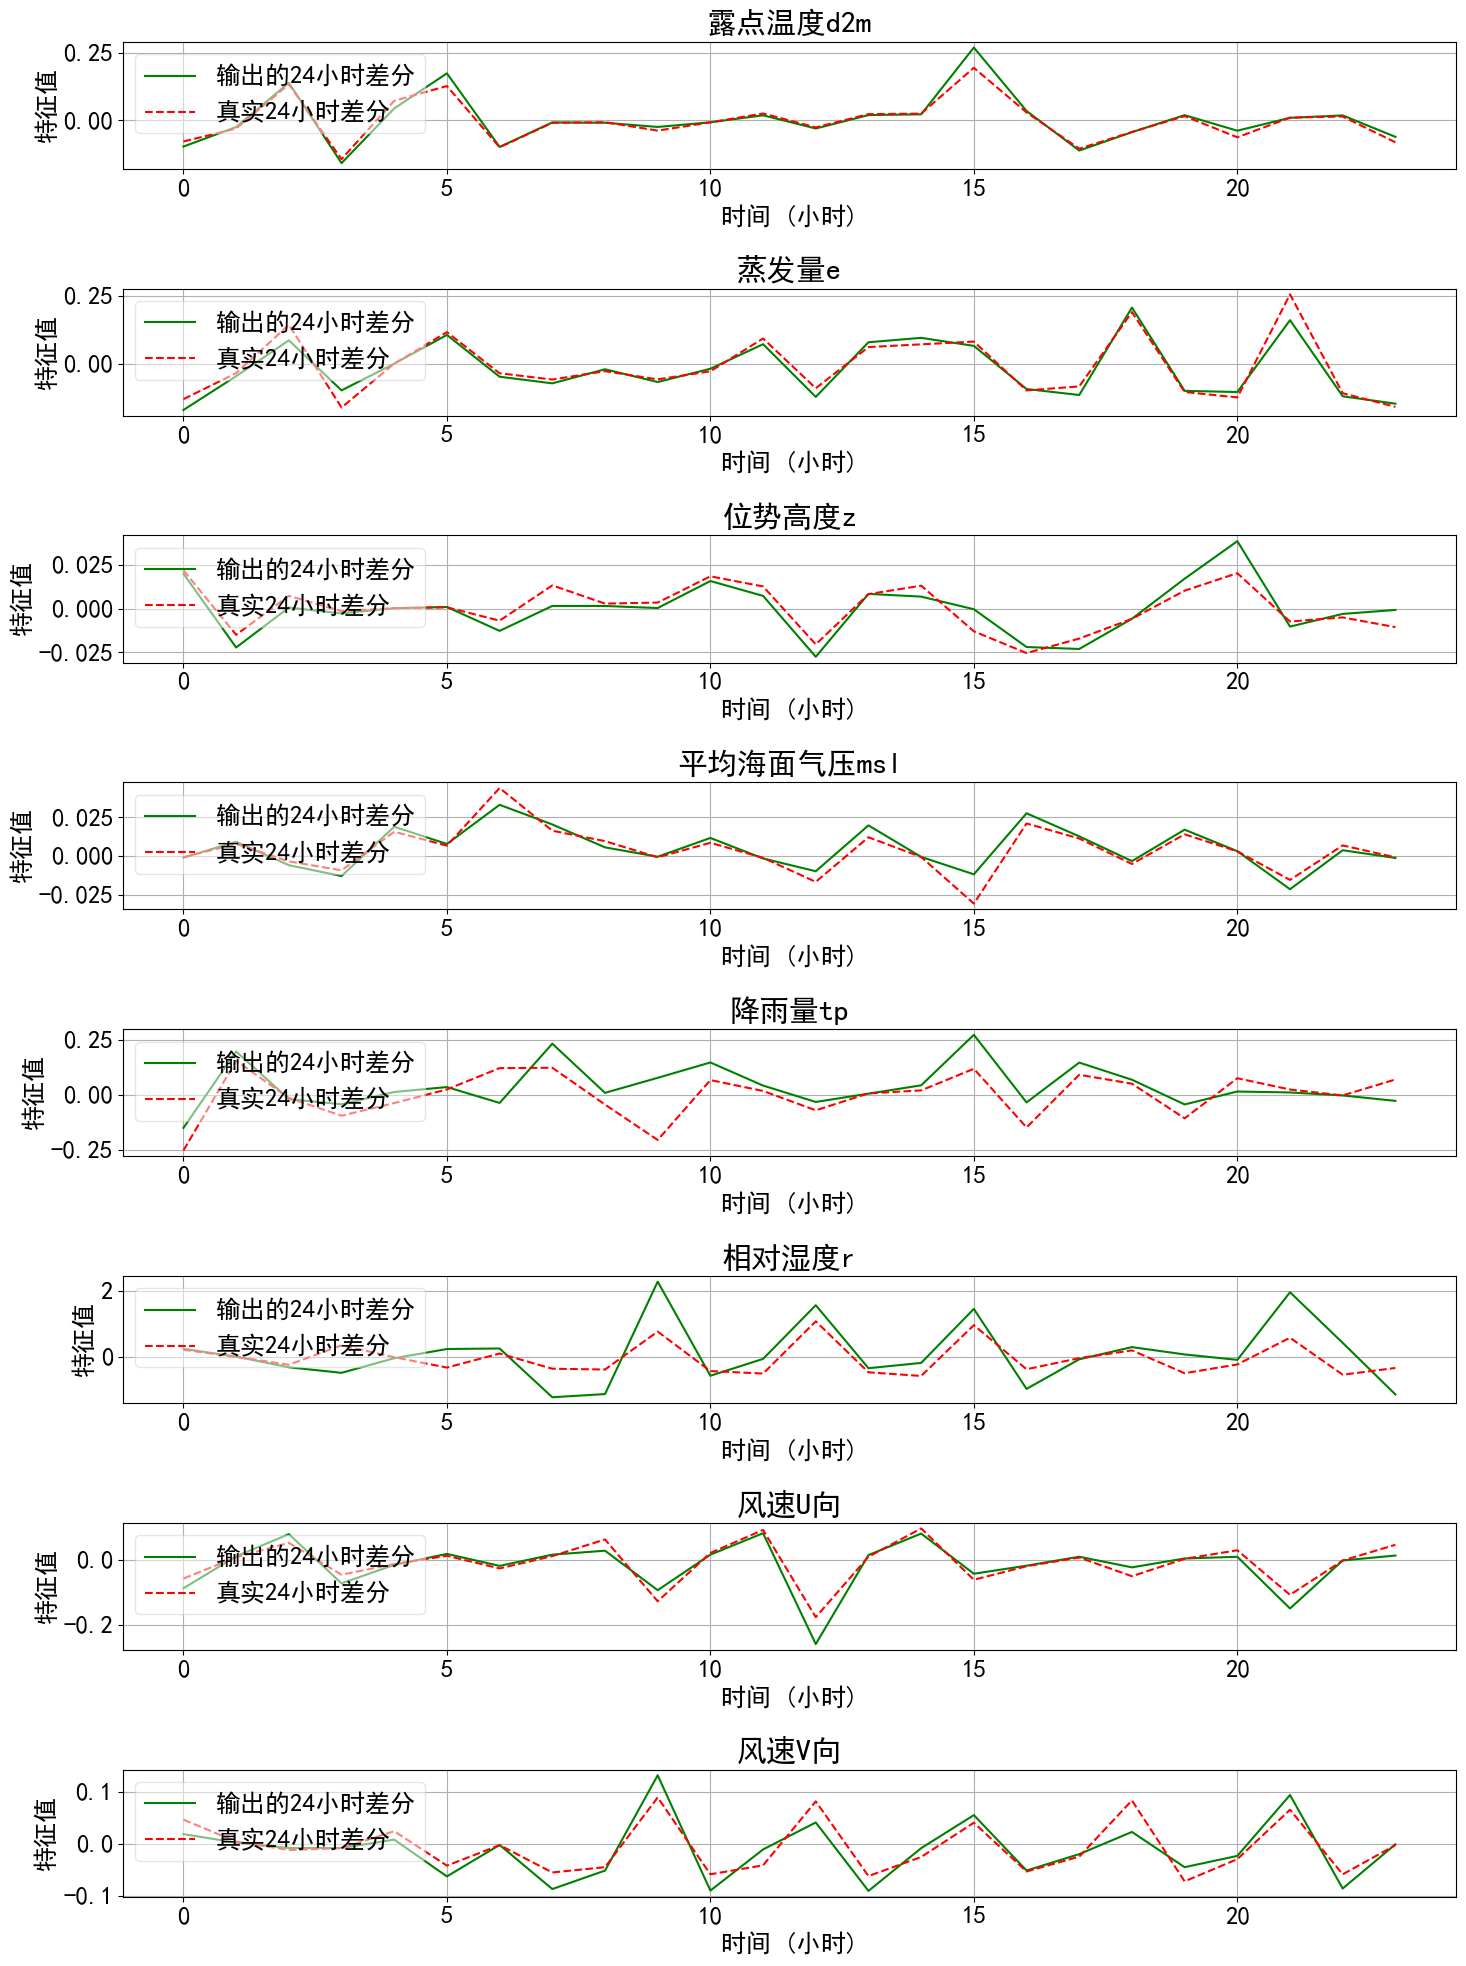

In [12]:
Num_Feature = 8
plt.rcParams.update({'font.size': 18})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl', '降雨量tp','相对湿度r','风速U向','风速V向']


Input = Predict_Value[0:9, :, :].unsqueeze(0)
print(Input.shape)



print(OutPut.shape, Diff_Data.shape)

# 绘制
plt.figure(figsize=(15, 20))
for i in range(OutPut.shape[1]):  # 遍历所有8个特征
    plt.subplot(Num_Feature, 1, i+1)
    plt.plot(range(0, 24), OutPut[:, i].cpu().detach().numpy(), 'g', label='输出的24小时差分')
    plt.plot(range(0, 24), Diff_Data[:, i].cpu().detach().numpy(), 'r--', label='真实24小时差分')
    plt.title(variable_names[i])
    plt.xlabel('时间 (小时)')
    plt.ylabel(f'特征值')
    plt.grid()
    plt.legend(loc='upper left', frameon=True, framealpha=0.5)  # framealpha 控制透明度
    plt.tight_layout()

plt.show()